In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import string
import time

In [2]:
# Download the colors dataset
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


In [3]:
# Read the data
colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), int(row[1]), int(row[2]), int(row[3])
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 174, 182, 87)


In [4]:
# In this experiment, we will train a char-baed RNN to generate a line of text
# that resembles this dataset (we'll treat each line as a string)
sentences = []
for row in colors_rgb:
  line = ' '.join([str(part) for part in row])
  sentences.append(line)
print(sentences[0])

parakeet 174 182 87


In [5]:
# vocabulary for our char-based RNN
chars = set()
for sentence in sentences:
  for char in sentence:
    chars.add(char)
    
# add a special char for padding
chars.add('<pad>')

vocab = sorted(set(chars))

# Create a mapping from unique characters to indices
char2idx = {u : i for i, u in enumerate(vocab)}
idx2char = {i : u for i, u in enumerate(vocab)}

# Vocab size
vocab_size = len(vocab)
print('vocab size:', vocab_size)
print(vocab)

vocab size: 38
[' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<pad>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [0]:
sentences

In [7]:
# vectorize the text
text_int = []
for sentence in sentences:
  int_sentence = [] 
  for c in sentence:
    int_sentence.append(char2idx[c])
  text_int.append(int_sentence)
print('Vectorized sentence', text_int[0])

Vectorized sentence [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8]


In [12]:
# pad sentences to max_length
max_length = 40
for sentence in text_int:
  while (len(sentence) < max_length):
    sentence.append(char2idx['<pad>'])
print('Padded sentences', text_int[0])

Padded sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [13]:
# truncate all sentences to max_length
for i in range(len(text_int)):
  sentence = text_int[i]
  if len(sentence) > max_length:
    text_int[i] = sentence[:max_length]
print("Truncated sentences", text_int[0])

Truncated sentences [27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [14]:
# Create training examples / targets
input_text = []
target_text = []

for i in range(len(text_int)):
  inps = text_int[i][:max_length-1]
  targ = text_int[i][1:max_length]
  input_text.append(inps)
  target_text.append(targ)
  
print("First training example, target")  
print(input_text[0])
print(target_text[0])

First training example, target
[27, 12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
[12, 29, 12, 22, 16, 16, 31, 0, 2, 8, 5, 0, 2, 9, 3, 0, 9, 8, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((input_text, target_text))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [0]:
class Model(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, units):
    super(Model, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dense1 = tf.keras.layers.Dense(128)
    self.dropout = tf.keras.layers.Dropout(0.5)
    self.dense2 = tf.keras.layers.Dense(128)
    self.batch = tf.keras.layers.BatchNormalization()
    self.fc = tf.keras.layers.Dense(vocab_size)
        
  def call(self, x):
    embedding = self.embedding(x)
    dense1 = self.dense1(embedding)
    dropout = self.dropout(dense1)
    dense2 = self.dense2(dropout)
    batch = self.batch(dense2)
    prediction = self.fc(dense2)
    return prediction

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
# Here, this is basically just a trick to avoid having 
# to one-hot encode the characters
# I don't think it will add much otherwise
# this would be more useful if we had a much larger vocabulary
embedding_dim = 128

# Number of RNN units
units = 256

model = Model(vocab_size, embedding_dim, units)

In [0]:
optimizer = tf.train.AdamOptimizer()

# Using sparse_softmax_cross_entropy so that we don't have to create one-hot vectors
def loss_function(labels, logits):
    return tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

In [137]:
model.build(tf.TensorShape([BATCH_SIZE, max_length]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     multiple                  4864      
_________________________________________________________________
dense_37 (Dense)             multiple                  16512     
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_38 (Dense)             multiple                  16512     
_________________________________________________________________
batch_normalization_3 (Batch multiple                  512       
_________________________________________________________________
dense_39 (Dense)             multiple                  4902      
Total params: 43,302
Trainable params: 43,046
Non-trainable params: 256
_________________________________________________________________


In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Checkpoint instance
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

In [139]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    
    for (batch, (input_seq, target_seq)) in enumerate(dataset):
          with tf.GradientTape() as tape:
              predictions = model(input_seq)
              loss = loss_function(target_seq, predictions)
              
          grads = tape.gradient(loss, model.variables)
          optimizer.apply_gradients(zip(grads, model.variables))

          if batch % 100 == 0:
              print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,
                                                            batch,
                                                            loss))

    print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print ('Time for epoch {} sec\n'.format(time.time() - start))
    checkpoint.save(file_prefix = checkpoint_prefix)

Epoch 1 Batch 0 Loss 3.6081
Epoch 1 Batch 100 Loss 1.4625
Epoch 1 Batch 200 Loss 1.3483
Epoch 1 Loss 1.3485
Time for epoch 4.949200630187988 sec

Epoch 2 Batch 0 Loss 1.2763
Epoch 2 Batch 100 Loss 1.2921
Epoch 2 Batch 200 Loss 1.3255
Epoch 2 Loss 1.3456
Time for epoch 4.7269792556762695 sec

Epoch 3 Batch 0 Loss 1.3295
Epoch 3 Batch 100 Loss 1.3244
Epoch 3 Batch 200 Loss 1.4120
Epoch 3 Loss 1.2812
Time for epoch 4.7447075843811035 sec

Epoch 4 Batch 0 Loss 1.3476
Epoch 4 Batch 100 Loss 1.3853
Epoch 4 Batch 200 Loss 1.3339
Epoch 4 Loss 1.2880
Time for epoch 4.721076726913452 sec

Epoch 5 Batch 0 Loss 1.3277
Epoch 5 Batch 100 Loss 1.3343
Epoch 5 Batch 200 Loss 1.3913
Epoch 5 Loss 1.2934
Time for epoch 4.736124515533447 sec

Epoch 6 Batch 0 Loss 1.3065
Epoch 6 Batch 100 Loss 1.3190
Epoch 6 Batch 200 Loss 1.3650
Epoch 6 Loss 1.2724
Time for epoch 4.734177827835083 sec

Epoch 7 Batch 0 Loss 1.3391
Epoch 7 Batch 100 Loss 1.2977
Epoch 7 Batch 200 Loss 1.3746
Epoch 7 Loss 1.3599
Time for epoch

In [140]:
!ls {checkpoint_dir}

checkpoint		     ckpt-5.data-00000-of-00001
ckpt-10.data-00000-of-00001  ckpt-5.index
ckpt-10.index		     ckpt-6.data-00000-of-00001
ckpt-1.data-00000-of-00001   ckpt-6.index
ckpt-1.index		     ckpt-7.data-00000-of-00001
ckpt-2.data-00000-of-00001   ckpt-7.index
ckpt-2.index		     ckpt-8.data-00000-of-00001
ckpt-3.data-00000-of-00001   ckpt-8.index
ckpt-3.index		     ckpt-9.data-00000-of-00001
ckpt-4.data-00000-of-00001   ckpt-9.index
ckpt-4.index


In [0]:
# This is a hack to let us use the model with a different 
# batch size later
model = Model(vocab_size, embedding_dim, units)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [142]:
input_eval

<tf.Tensor: id=6652760, shape=(1, 1), dtype=int32, numpy=array([[11]], dtype=int32)>

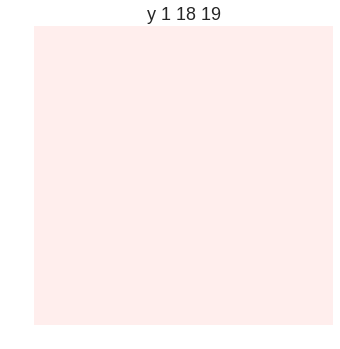

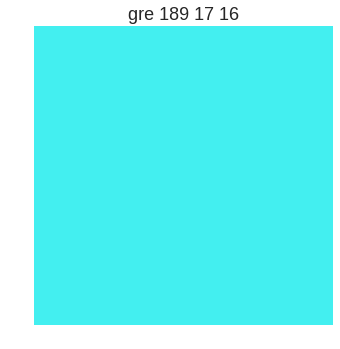

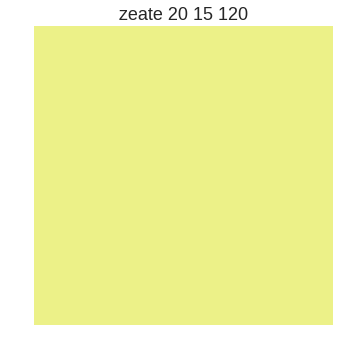

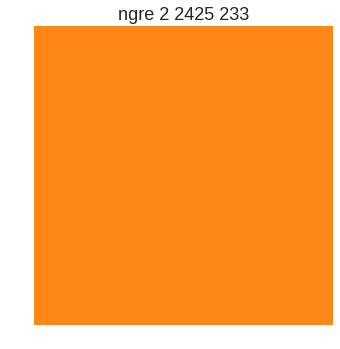

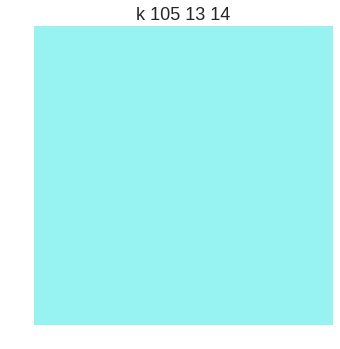

In [155]:
# Evaluation step (generating text using the learned model)

# Number of characters to generate
num_generate = max_length

k = 0
while k < 5:
  # You can change the start string to experiment
  start_string = random.choice(string.ascii_lowercase)

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 0.5


  # Here batch size == 1

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  generated_color = start_string + ''.join(text_generated).replace('<pad>', '')

  parts = generated_color.split()
  if len(parts) >= 4:
    if parts[-3].isdigit() and parts[-2].isdigit() and parts[-1].isdigit():
      generated_color = ' '.join(map(str,[parts[0],parts[-3],parts[-2],parts[-1]]))
      r = float(parts[-3])
      g = float(parts[-2])
      b = float(parts[-1])
      plt.clf()
      _ = plt.imshow([[(r, g, b)]])
      _ = plt.axis('off')
      _ = plt.title(generated_color, fontsize=18)
      plt.show()
      k += 1

 

## OK to change the output rules?

40